## <center><b>LGMVIP - Data Science</b></center>
### <center><b>Task 3 - Music Recommendation (Beginner Level)</b></center>
#### <center><b>Author : Akshay Paunikar</b></center>

<h4><b>Objective:</b></h4>
In this task, you will be asked to predict the chances of a user listening to a song repetitively after the first observable listening event within a time window was triggered. If there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, its target is marked 1, and 0 otherwise in the training set. The same rule applies to the testing set.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
# Load all the datasets required for analysis
train = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/LGMVIP-Data Science/Task 3 - Music Recommendation/train.csv")
test = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/LGMVIP-Data Science/Task 3 - Music Recommendation/test.csv")
songs = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/LGMVIP-Data Science/Task 3 - Music Recommendation/songs.csv")
song_extra_info = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/LGMVIP-Data Science/Task 3 - Music Recommendation/song_extra_info.csv")
members = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/LGMVIP-Data Science/Task 3 - Music Recommendation/members.csv")

<h4><b>Exploratory Data Analysis (EDA):</b></h4>

In [ ]:
# Check the dimensions of each data
print("train shape :", train.shape)
print("test shape :", test.shape)
print("songs shape :", songs.shape)
print("song_extra_info shape :", song_extra_info.shape)
print("members shape :", members.shape)

train shape : (7377418, 6)
test shape : (2556790, 6)
songs shape : (2296320, 7)
song_extra_info shape : (2295971, 3)
members shape : (34403, 7)


In [ ]:
# Now lets check the first 5 records from each data
# train data
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [ ]:
# test data
test.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [ ]:
# songs data
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [ ]:
# song_extra_info data
song_extra_info.head()

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


In [ ]:
# members data
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [ ]:
# Check datatypes present in each data
# train data
train.dtypes

msno                  object
song_id               object
source_system_tab     object
source_screen_name    object
source_type           object
target                 int64
dtype: object

In [ ]:
# test data
test.dtypes

id                     int64
msno                  object
song_id               object
source_system_tab     object
source_screen_name    object
source_type           object
dtype: object

In [ ]:
# songs data
songs.dtypes

song_id         object
song_length      int64
genre_ids       object
artist_name     object
composer        object
lyricist        object
language       float64
dtype: object

In [ ]:
# song_extra_info data
song_extra_info.dtypes

song_id    object
name       object
isrc       object
dtype: object

In [ ]:
# members data
members.dtypes

msno                      object
city                       int64
bd                         int64
gender                    object
registered_via             int64
registration_init_time     int64
expiration_date            int64
dtype: object

In [ ]:
# Let's see some descriptive statistics from each data
# train data
train.describe(include='all')

,msno,song_id,source_system_tab,source_screen_name,source_type,target
count,7377418,7377418,7352569,6962614,7355879,7.377418e+06
unique,30755,359966,8,20,12,NaN
top,MXIMDXO0j3UpaT7FvOSGW6Y5zfhlh+xYjTqGoUdMzEE=,reXuGcEWDDCnL0K3Th//3DFG4S1ACSpJMzA+CFipo1g=,my library,Local playlist more,local-library,NaN
freq,5819,13973,3684730,3228202,2261399,NaN
mean,NaN,NaN,NaN,NaN,NaN,5.035171e-01
std,NaN,NaN,NaN,NaN,NaN,4.999877e-01
min,NaN,NaN,NaN,NaN,NaN,0.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,0.000000e+00
50%,NaN,NaN,NaN,NaN,NaN,1.000000e+00
75%,NaN,NaN,NaN,NaN,NaN,1.000000e+00


In [ ]:
# test data
test.describe(include='all')

,id,msno,song_id,source_system_tab,source_screen_name,source_type
count,2.556790e+06,2556790,2556790,2548348,2393907,2549493
unique,NaN,25131,224753,8,22,12
top,NaN,KGXNZ/H3VxvET/+rGxlrAe7Gpz2eKMXyuSg3xh8Ij1M=,ZcKgNis1AP1LA0sdtIddrtk7P04iiJzJrXvwXdT/X3Q=,my library,Local playlist more,online-playlist
freq,NaN,2489,8320,1019492,845115,774532
mean,1.278394e+06,NaN,NaN,NaN,NaN,NaN
std,7.380818e+05,NaN,NaN,NaN,NaN,NaN
min,0.000000e+00,NaN,NaN,NaN,NaN,NaN
25%,6.391972e+05,NaN,NaN,NaN,NaN,NaN
50%,1.278394e+06,NaN,NaN,NaN,NaN,NaN
75%,1.917592e+06,NaN,NaN,NaN,NaN,NaN


In [ ]:
# songs data
songs.describe(include='all')

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
count,2296320,2.296320e+06,2202204,2296320,1224966,351052,2.296319e+06
unique,2296320,NaN,1045,222363,329823,110925,NaN
top,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,NaN,465,Various Artists,Neuromancer,Traditional,NaN
freq,1,NaN,567911,145916,17888,1751,NaN
mean,NaN,2.469935e+05,NaN,NaN,NaN,NaN,3.237800e+01
std,NaN,1.609200e+05,NaN,NaN,NaN,NaN,2.433241e+01
min,NaN,1.850000e+02,NaN,NaN,NaN,NaN,-1.000000e+00
25%,NaN,1.836000e+05,NaN,NaN,NaN,NaN,-1.000000e+00
50%,NaN,2.266270e+05,NaN,NaN,NaN,NaN,5.200000e+01
75%,NaN,2.772690e+05,NaN,NaN,NaN,NaN,5.200000e+01


In [ ]:
# song_extra_info data
song_extra_info.describe(include='all')

,song_id,name,isrc
count,2295971,2295969,2159423
unique,2295971,1168979,1806825
top,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,Intro,GBPS81518952
freq,1,1734,207


In [ ]:
# members data
members.describe(include='all')

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
count,34403,34403.000000,34403.000000,14501,34403.000000,3.440300e+04,3.440300e+04
unique,34403,NaN,NaN,2,NaN,NaN,NaN
top,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,NaN,NaN,male,NaN,NaN,NaN
freq,1,NaN,NaN,7405,NaN,NaN,NaN
mean,NaN,5.371276,12.280935,NaN,5.953376,2.013994e+07,2.016901e+07
std,NaN,6.243929,18.170251,NaN,2.287534,2.954015e+04,7.320925e+03
min,NaN,1.000000,-43.000000,NaN,3.000000,2.004033e+07,1.970010e+07
25%,NaN,1.000000,0.000000,NaN,4.000000,2.012103e+07,2.017020e+07
50%,NaN,1.000000,0.000000,NaN,7.000000,2.015090e+07,2.017091e+07
75%,NaN,10.000000,25.000000,NaN,9.000000,2.016110e+07,2.017093e+07


In [ ]:
# Lets look at the concise summary of each data
# train data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 6 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   msno                object
 1   song_id             object
 2   source_system_tab   object
 3   source_screen_name  object
 4   source_type         object
 5   target              int64 
dtypes: int64(1), object(5)
memory usage: 337.7+ MB


In [ ]:
# test data
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556790 entries, 0 to 2556789
Data columns (total 6 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   id                  int64 
 1   msno                object
 2   song_id             object
 3   source_system_tab   object
 4   source_screen_name  object
 5   source_type         object
dtypes: int64(1), object(5)
memory usage: 117.0+ MB


In [ ]:
# songs data
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296320 entries, 0 to 2296319
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   song_id      object 
 1   song_length  int64  
 2   genre_ids    object 
 3   artist_name  object 
 4   composer     object 
 5   lyricist     object 
 6   language     float64
dtypes: float64(1), int64(1), object(5)
memory usage: 122.6+ MB


In [ ]:
# song_extra_info data
song_extra_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2295971 entries, 0 to 2295970
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   song_id  object
 1   name     object
 2   isrc     object
dtypes: object(3)
memory usage: 52.6+ MB


In [ ]:
# members data
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34403 entries, 0 to 34402
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   msno                    34403 non-null  object
 1   city                    34403 non-null  int64 
 2   bd                      34403 non-null  int64 
 3   gender                  14501 non-null  object
 4   registered_via          34403 non-null  int64 
 5   registration_init_time  34403 non-null  int64 
 6   expiration_date         34403 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.8+ MB


##### Now we will check the percentage of null values in each data

In [ ]:
# Create a function to calculate percentage of missing values
def missing_percentage(data):
    for i in data.columns:
        j = data[i].isnull().sum()
        k = data.shape[0]
        p = (j/k)*100
        print(i, round(p,2))

In [ ]:
# missing values in train data
missing_percentage(train)

msno 0.0
song_id 0.0
source_system_tab 0.34
source_screen_name 5.62
source_type 0.29
target 0.0


In [ ]:
# missing values in test data
missing_percentage(test)

id 0.0
msno 0.0
song_id 0.0
source_system_tab 0.33
source_screen_name 6.37
source_type 0.29


In [ ]:
# missing values in songs data
missing_percentage(songs)

song_id 0.0
song_length 0.0
genre_ids 4.1
artist_name 0.0
composer 46.66
lyricist 84.71
language 0.0


In [ ]:
# missing values in song_extra_info data
missing_percentage(song_extra_info)

song_id 0.0
name 0.0
isrc 5.95


In [ ]:
# missing values in members data
missing_percentage(members)

msno 0.0
city 0.0
bd 0.0
gender 57.85
registered_via 0.0
registration_init_time 0.0
expiration_date 0.0


In [ ]:
# train data has null values in source_system_tab, source_screen_name, source_type so we will replace those values by 'unknown'
train['source_system_tab'] = train['source_system_tab'].fillna('unknown')
train['source_screen_name'] = train['source_screen_name'].fillna('unknown')
train['source_type'] = train['source_type'].fillna('unknown')

In [ ]:
# test data has null values in source_system_tab, source_screen_name, source_type so we will replace those values by 'unknown'
test['source_system_tab'] = test['source_system_tab'].fillna('unknown')
test['source_screen_name'] = test['source_screen_name'].fillna('unknown')
test['source_type'] = test['source_type'].fillna('unknown')

In [ ]:
# songs data has null values in genre_ids, composer, lyricist so we will replace those values by 'unknown'
songs['genre_ids'] = songs['genre_ids'].fillna('unknown')
songs['composer'] = songs['composer'].fillna('unknown')
songs['lyricist'] = songs['lyricist'].fillna('unknown')

In [ ]:
# song_extra_info data has null values in isrc column so we will replace those values by 'unknown'
song_extra_info['isrc'] = song_extra_info['isrc'].fillna('unknown')

In [ ]:
# Now the members data has null values in gender column so we will replace those values by 'unknown'
members['gender'] = members['gender'].fillna(value='unknown')

Now we have successfully replaced null values in our data.

Let's check the balance of the data by analysing the "target" column in train data

In [ ]:
train['target'].value_counts()

1    3714656
0    3662762
Name: target, dtype: int64

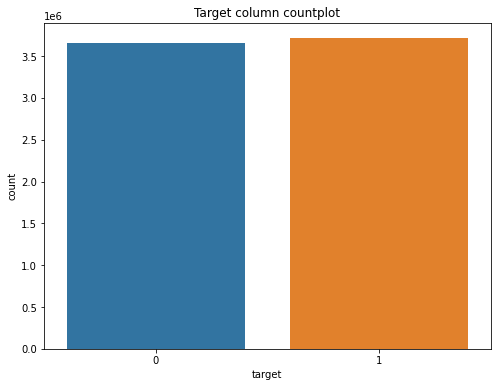

In [ ]:
# Lets plot this using countplot
plt.figure(figsize=(8,6))
sns.countplot(x='target', data=train)
plt.title("Target column countplot")
plt.show()

From above analysis we can say that we have almost equal number of counts for class "1" and "0" in the target column and data is well balanced.

In [ ]:
train['source_system_tab'].value_counts()

my library      3684730
discover        2179252
search           623286
radio            476701
listen with      212266
explore          167949
unknown           24849
notification       6185
settings           2200
Name: source_system_tab, dtype: int64

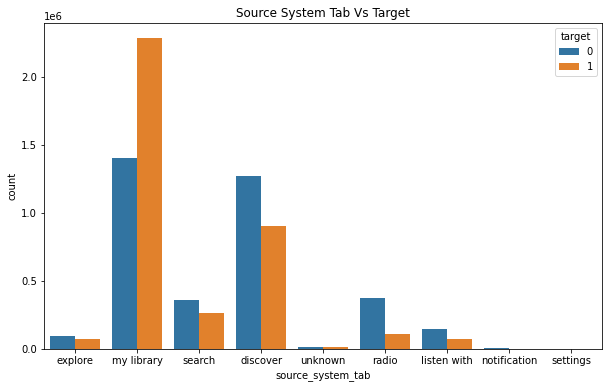

In [ ]:
# source_system_tab w.r.t target
plt.figure(figsize=(10,6))
sns.countplot(x='source_system_tab', data=train, hue='target')
plt.title("Source System Tab Vs Target")
plt.show()

In [ ]:
train['source_screen_name'].value_counts()

Local playlist more     3228202
Online playlist more    1294689
Radio                    474467
Album more               420156
unknown                  414804
Search                   298487
Artist more              252429
Discover Feature         244246
Discover Chart           213658
Others profile more      201795
Discover Genre            82202
My library                75980
Explore                   72342
Unknown                   54170
Discover New              15955
Search Trends             13632
Search Home               13482
My library_Search          6451
Self profile more           212
Concert                      47
Payment                      12
Name: source_screen_name, dtype: int64

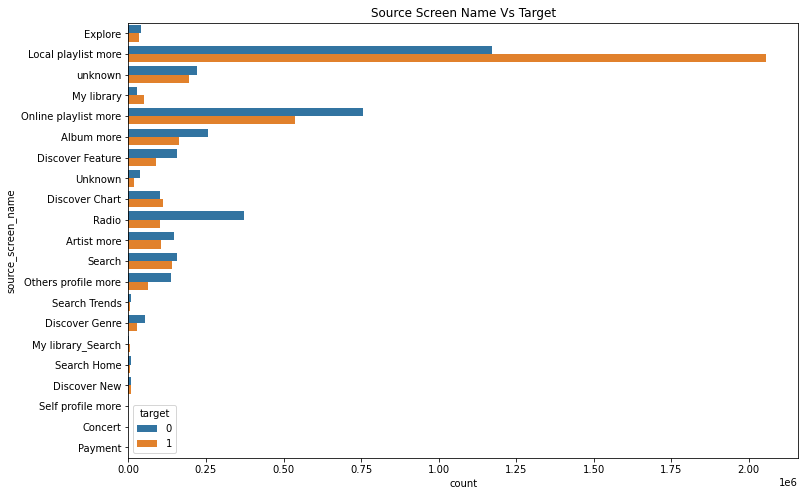

In [ ]:
# source_screen_name w.r.t target
plt.figure(figsize=(12,8))
sns.countplot(y='source_screen_name', data=train, hue='target', orient='v')
plt.title("Source Screen Name Vs Target")
plt.show()

In [ ]:
train['source_type'].value_counts()

local-library             2261399
online-playlist           1967924
local-playlist            1079503
radio                      483109
album                      477344
top-hits-for-artist        423614
song                       244722
song-based-playlist        210527
listen-with                192842
unknown                     21539
topic-article-playlist      11194
artist                       3038
my-daily-playlist             663
Name: source_type, dtype: int64

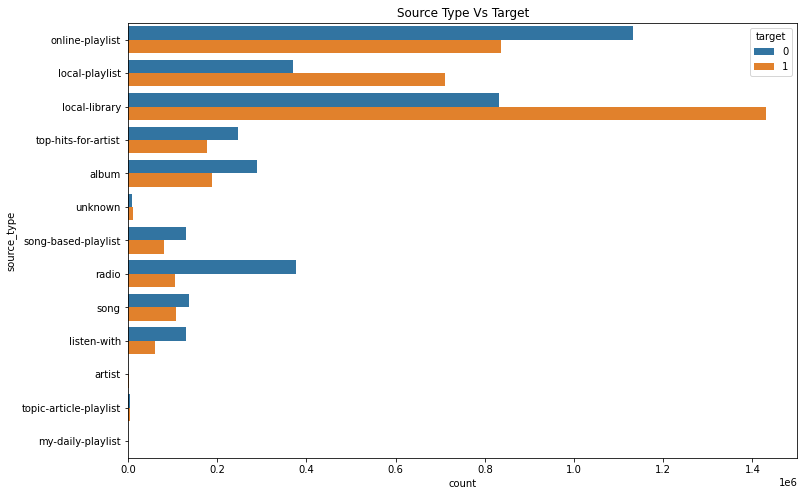

In [ ]:
# source_type w.r.t target
plt.figure(figsize=(12,8))
sns.countplot(y='source_type', data=train, hue='target', orient='v')
plt.title("Source Type Vs Target")
plt.show()

In [ ]:
members['gender'].value_counts()

unknown    19902
male        7405
female      7096
Name: gender, dtype: int64

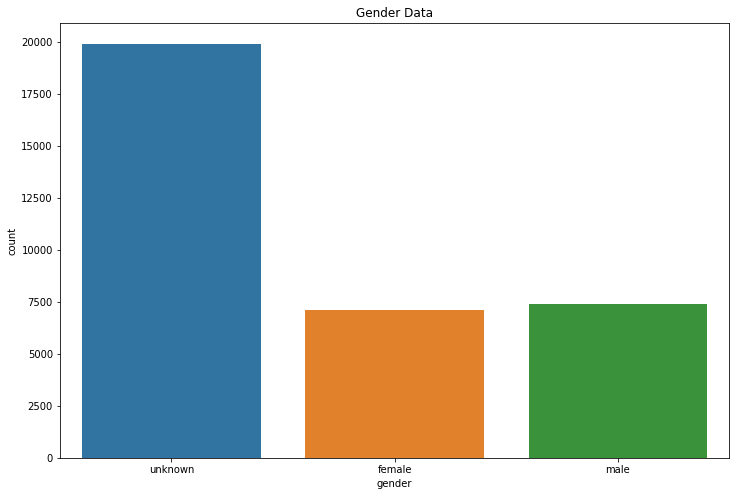

In [ ]:
# source_type w.r.t target
plt.figure(figsize=(12,8))
sns.countplot(x='gender', data=members)
plt.title("Gender Data")
plt.show()

In [ ]:
# Now we will merge the all dataset 
train_data = pd.merge(left=train, right=members, how='left', on='msno')
song_data = pd.merge(left=songs, right=song_extra_info, how='left', on='song_id')
test_data = pd.merge(left=test, right=members, how='left', on='msno')

In [ ]:
# Creating a final train and test data
train_final = pd.merge(left=train_data, right=song_data, how='left', on='song_id')
test_final = pd.merge(left=test_data, right=song_data, how='left', on='song_id')

In [ ]:
# Check for any missing values in train data
missing_percentage(train_final)

msno 0.0
song_id 0.0
source_system_tab 0.0
source_screen_name 0.0
source_type 0.0
target 0.0
city 0.0
bd 0.0
gender 0.0
registered_via 0.0
registration_init_time 0.0
expiration_date 0.0
song_length 0.0
genre_ids 0.0
artist_name 0.0
composer 0.0
lyricist 0.0
language 0.0
name 0.02
isrc 0.02


In [ ]:
# Check for any missing values in test data
missing_percentage(test_final)

id 0.0
msno 0.0
song_id 0.0
source_system_tab 0.0
source_screen_name 0.0
source_type 0.0
city 0.0
bd 0.0
gender 0.0
registered_via 0.0
registration_init_time 0.0
expiration_date 0.0
song_length 0.0
genre_ids 0.0
artist_name 0.0
composer 0.0
lyricist 0.0
language 0.0
name 0.03
isrc 0.03


In [ ]:
# Now we will fill the missing values in train and test data by 'unknown'
train_final['name'] = train_final['name'].fillna('unknown')
train_final['isrc'] = train_final['isrc'].fillna('unknown')
test_final['name'] = test_final['name'].fillna('unknown')
test_final['isrc'] = test_final['isrc'].fillna('unknown')

In [ ]:
# Converting 'registration_init_time' and 'expiration_date' into datetime format
train_final['registration_init_time'] = pd.to_datetime(train_final['registration_init_time'], format='%Y%m%d')
train_final['expiration_date'] = pd.to_datetime(train_final['expiration_date'], format='%Y%m%d')
test_final['registration_init_time'] = pd.to_datetime(test_final['registration_init_time'], format='%Y%m%d')
test_final['expiration_date'] = pd.to_datetime(test_final['expiration_date'], format='%Y%m%d')

In [ ]:
# Now we will extract 'year', 'month' and 'day' from 'registration_init_time', 'expiration_date' in the train data
train_final['registration_year'] = train_final['registration_init_time'].dt.year
train_final['registration_month'] = train_final['registration_init_time'].dt.month
train_final['registration_day'] = train_final['registration_init_time'].dt.day
train_final['expiration_year'] = train_final['expiration_date'].dt.year
train_final['expiration_month'] = train_final['expiration_date'].dt.month
train_final['expiration_day'] = train_final['expiration_date'].dt.day

In [ ]:
# Now we will extract 'year', 'month' and 'day' from 'registration_init_time', 'expiration_date' in the test data
test_final['registration_year'] = test_final['registration_init_time'].dt.year
test_final['registration_month'] = test_final['registration_init_time'].dt.month
test_final['registration_day'] = test_final['registration_init_time'].dt.day
test_final['expiration_year'] = test_final['expiration_date'].dt.year
test_final['expiration_month'] = test_final['expiration_date'].dt.month
test_final['expiration_day'] = test_final['expiration_date'].dt.day

In [ ]:
# Drop unnecessary column
train_final = train_final.drop(['registration_init_time', 'expiration_date'], axis=1)
test_final = test_final.drop(['registration_init_time', 'expiration_date','id'], axis=1)

In [ ]:
# Check first 5 records from train_final data
train_final.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,...,lyricist,language,name,isrc,registration_year,registration_month,registration_day,expiration_year,expiration_month,expiration_day
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,unknown,7,...,unknown,52.0,Good Grief,GBUM71602854,2012,1,2,2017,10,5
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,female,9,...,unknown,52.0,Lords of Cardboard,US3C69910183,2011,5,25,2017,9,11
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,female,9,...,unknown,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,2011,5,25,2017,9,11
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,24,female,9,...,unknown,-1.0,Disco Africa,GBUQH1000063,2011,5,25,2017,9,11
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,0,unknown,7,...,unknown,52.0,Sleep Without You,QM3E21606003,2012,1,2,2017,10,5


In [ ]:
# Check first 5 records from test_final data
test_final.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,city,bd,gender,registered_via,song_length,...,lyricist,language,name,isrc,registration_year,registration_month,registration_day,expiration_year,expiration_month,expiration_day
0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library,1,0,unknown,7,224130.0,...,unknown,3.0,愛其實很殘忍,TWUM71400047,2016,2,19,2017,9,18
1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library,1,0,unknown,7,320470.0,...,孫燕姿/易家揚,3.0,她說,TWB671005201,2016,2,19,2017,9,18
2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,unknown,song-based-playlist,1,0,unknown,4,315899.0,...,Yu Takahashi,17.0,subarashiki nichijo,JPWP01070260,2016,11,17,2016,11,24
3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio,3,30,male,9,285210.0,...,unknown,52.0,Hold Me| Thrill Me| Kiss Me| Kill Me,GBAAN0201228,2007,7,25,2017,4,30
4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio,3,30,male,9,197590.0,...,unknown,-1.0,Om Yoga,ITO101121898,2007,7,25,2017,4,30


In [ ]:
# Check the dimensions
train_final.shape

(7377418, 24)

In [ ]:
# Check the dimensions
test_final.shape

(2556790, 23)

In [ ]:
# Extract 'object' datatype columns from train_final data
objectcols_train = train_final.select_dtypes(include='object')
objectcols_train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,gender,genre_ids,artist_name,composer,lyricist,name,isrc
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,unknown,359,Bastille,Dan Smith| Mark Crew,unknown,Good Grief,GBUM71602854
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,female,1259,Various Artists,unknown,unknown,Lords of Cardboard,US3C69910183
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,female,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,unknown,Hip Hop Is Dead(Album Version (Edited)),USUM70618761
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,female,1019,Soundway,Kwadwo Donkoh,unknown,Disco Africa,GBUQH1000063
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,unknown,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,unknown,Sleep Without You,QM3E21606003


In [ ]:
# Get the column names
objectcols_train.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'gender', 'genre_ids', 'artist_name', 'composer',
       'lyricist', 'name', 'isrc'],
      dtype='object')

In [ ]:
# Now we will use ordinal encoder to convert into numeric values 
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [ ]:
# fit and transform the object columns in train data using ordinal encoder
objectcols_train_encoded = ordinal_encoder.fit_transform(objectcols_train)

In [ ]:
# Create a dataframe
objectcols_train = pd.DataFrame(objectcols_train_encoded, columns=objectcols_train.columns)

In [ ]:
# Check the first 5 records
objectcols_train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,gender,genre_ids,artist_name,composer,lyricist,name,isrc
0,8158.0,74679.0,1.0,7.0,6.0,2.0,285.0,3277.0,14581.0,22976.0,51442.0,65234.0
1,17259.0,223479.0,3.0,8.0,4.0,0.0,90.0,31960.0,64996.0,22976.0,81294.0,195646.0
2,17259.0,120758.0,3.0,8.0,4.0,0.0,90.0,21372.0,45057.0,22976.0,57304.0,253595.0
3,17259.0,23707.0,3.0,8.0,4.0,0.0,6.0,27439.0,36700.0,22976.0,34727.0,65562.0
4,8158.0,33308.0,1.0,7.0,6.0,2.0,2.0,4472.0,8485.0,22976.0,121784.0,131924.0


In [ ]:
# Now we will drop the original columns
train_final = train_final.drop(['msno', 'song_id', 'source_system_tab', 'source_screen_name','source_type', 'gender', 'genre_ids',
                                'artist_name', 'composer','lyricist', 'name', 'isrc'], axis=1)

In [ ]:
# Concatenate the two dataframes
train_final = pd.concat([train_final, objectcols_train], axis=1)

In [ ]:
# Check first 5 records
train_final.head()

,target,city,bd,registered_via,song_length,language,registration_year,registration_month,registration_day,expiration_year,...,source_system_tab,source_screen_name,source_type,gender,genre_ids,artist_name,composer,lyricist,name,isrc
0,1,1,0,7,206471.0,52.0,2012,1,2,2017,...,1.0,7.0,6.0,2.0,285.0,3277.0,14581.0,22976.0,51442.0,65234.0
1,1,13,24,9,284584.0,52.0,2011,5,25,2017,...,3.0,8.0,4.0,0.0,90.0,31960.0,64996.0,22976.0,81294.0,195646.0
2,1,13,24,9,225396.0,52.0,2011,5,25,2017,...,3.0,8.0,4.0,0.0,90.0,21372.0,45057.0,22976.0,57304.0,253595.0
3,1,13,24,9,255512.0,-1.0,2011,5,25,2017,...,3.0,8.0,4.0,0.0,6.0,27439.0,36700.0,22976.0,34727.0,65562.0
4,1,1,0,7,187802.0,52.0,2012,1,2,2017,...,1.0,7.0,6.0,2.0,2.0,4472.0,8485.0,22976.0,121784.0,131924.0


In [ ]:
# Extract 'object' datatype columns from test_final data
objectcols_test = test_final.select_dtypes(include='object')
objectcols_test.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,gender,genre_ids,artist_name,composer,lyricist,name,isrc
0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library,unknown,458,梁文音 (Rachel Liang),Qi Zheng Zhang,unknown,愛其實很殘忍,TWUM71400047
1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library,unknown,465,林俊傑 (JJ Lin),林俊傑,孫燕姿/易家揚,她說,TWB671005201
2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,unknown,song-based-playlist,unknown,2022,Yu Takahashi (高橋優),Yu Takahashi,Yu Takahashi,subarashiki nichijo,JPWP01070260
3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio,male,465,U2,The Edge| Adam Clayton| Larry Mullen| Jr.,unknown,Hold Me| Thrill Me| Kiss Me| Kill Me,GBAAN0201228
4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio,male,873,Yoga Mr Sound,Neuromancer,unknown,Om Yoga,ITO101121898


In [ ]:
# Get the column names
objectcols_test.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'gender', 'genre_ids', 'artist_name', 'composer',
       'lyricist', 'name', 'isrc'],
      dtype='object')

In [ ]:
# fit and transform the object columns in test data using ordinal encoder
objectcols_test_encoded = ordinal_encoder.transform(objectcols_test)

In [ ]:
# Create a dataframe
objectcols_test = pd.DataFrame(objectcols_test_encoded, columns=objectcols_test.columns)

In [ ]:
# Check the first 5 records
objectcols_test.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,gender,genre_ids,artist_name,composer,lyricist,name,isrc
0,15860.0,195728.0,3.0,8.0,3.0,2.0,337.0,37300.0,49504.0,22976.0,193361.0,190462.0
1,15860.0,348995.0,3.0,8.0,3.0,2.0,344.0,37130.0,70042.0,25713.0,184575.0,169774.0
2,862.0,60366.0,0.0,20.0,9.0,2.0,185.0,33388.0,63931.0,22350.0,162806.0,109163.0
3,1669.0,359327.0,5.0,14.0,7.0,1.0,344.0,31571.0,58754.0,22976.0,57658.0,38153.0
4,1669.0,137382.0,5.0,14.0,7.0,1.0,486.0,33209.0,45823.0,22976.0,99260.0,83042.0


In [ ]:
# Now we will drop the original columns
test_final = test_final.drop(['msno', 'song_id', 'source_system_tab', 'source_screen_name', 'source_type', 'gender', 'genre_ids',
                              'artist_name', 'composer', 'lyricist', 'name', 'isrc'], axis=1)

In [ ]:
# Concatenate the two dataframes
test_final = pd.concat([test_final, objectcols_test], axis=1)

In [ ]:
# Check first 5 records
test_final.head()

,city,bd,registered_via,song_length,language,registration_year,registration_month,registration_day,expiration_year,expiration_month,...,source_system_tab,source_screen_name,source_type,gender,genre_ids,artist_name,composer,lyricist,name,isrc
0,1,0,7,224130.0,3.0,2016,2,19,2017,9,...,3.0,8.0,3.0,2.0,337.0,37300.0,49504.0,22976.0,193361.0,190462.0
1,1,0,7,320470.0,3.0,2016,2,19,2017,9,...,3.0,8.0,3.0,2.0,344.0,37130.0,70042.0,25713.0,184575.0,169774.0
2,1,0,4,315899.0,17.0,2016,11,17,2016,11,...,0.0,20.0,9.0,2.0,185.0,33388.0,63931.0,22350.0,162806.0,109163.0
3,3,30,9,285210.0,52.0,2007,7,25,2017,4,...,5.0,14.0,7.0,1.0,344.0,31571.0,58754.0,22976.0,57658.0,38153.0
4,3,30,9,197590.0,-1.0,2007,7,25,2017,4,...,5.0,14.0,7.0,1.0,486.0,33209.0,45823.0,22976.0,99260.0,83042.0


In [ ]:
# train_final.to_csv("train_final.csv")
# test_final.to_csv("test_final.csv")

In [ ]:
train_final = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/LGMVIP-Data Science/Task 3 - Music Recommendation/train_final.csv")
test_final = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/LGMVIP-Data Science/Task 3 - Music Recommendation/test_final.csv")

In [ ]:
# Independent and dependent features
X = train_final.drop('target', axis=1)
y = train_final.target

In [ ]:
# Create an instance of Standard Scaler
ss = StandardScaler()

In [ ]:
# fit and transform Standard Scaler on X
X = ss.fit_transform(X)

In [ ]:
# transform the test data
test_final_scaled = ss.transform(test_final)

In [ ]:
# records in X
X

array([[-1.73205057, -0.98039263, -0.81371856, ...,  0.02662601,
        -1.45374761, -1.55123182],
       [-1.7320501 ,  0.82639434,  0.29973964, ...,  0.02662601,
        -1.00510576,  0.46102773],
       [-1.73204963,  0.82639434,  0.29973964, ...,  0.02662601,
        -1.36564837,  1.35518185],
       ...,
       [ 1.73204963, -0.98039263, -0.81371856, ...,  0.39399152,
        -1.58800051, -0.14205454],
       [ 1.7320501 , -0.37813031, -0.81371856, ...,  0.02662601,
         0.12326186,  1.01916235],
       [ 1.73205057, -0.37813031, -0.81371856, ..., -0.68919966,
        -0.09348452, -2.14826552]])

In [ ]:
# records in test data
test_final_scaled

array([[-1.73205057, -0.98039263, -0.81371856, ...,  0.02662601,
         0.6791347 ,  0.38103851],
       [-1.7320501 , -0.98039263, -0.81371856, ...,  0.41862578,
         0.54709104,  0.06182229],
       [-1.73204963, -0.98039263, -0.81371856, ..., -0.06303123,
         0.21992755, -0.87340655],
       ...,
       [-0.53149911,  0.82639434,  0.29973964, ...,  1.36632855,
         0.6738746 ,  0.14986598],
       [-0.53149864,  0.82639434,  0.29973964, ...,  0.02662601,
        -2.22687781, -2.55780906],
       [-0.53149817,  0.82639434,  0.29973964, ..., -3.26419559,
        -2.22687781, -2.55780906]])

In [ ]:
# Create train and test data from training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
# create an instance of LGBMClassifier
lgb = LGBMClassifier(boosting_type='gbdt', num_leaves=896, learning_rate=0.2, objective='binary', max_bin=256)

In [ ]:
# fit lightgbm on training data
lgb.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.2, max_bin=256, num_leaves=896,
               objective='binary')

In [ ]:
# Check our model score
lgb.score(X_train, y_train)

0.7467561237072518

In [ ]:
# predict on the test data
lgb_pred = lgb.predict(X_test)

In [ ]:
# Check performance metrics

# Accuracy Score :
print("Accuracy Score :", accuracy_score(y_test, lgb_pred))

# Confusion Matrix :
print("Confusion Matrix :\n", confusion_matrix(y_test, lgb_pred))

# Classification Report :
print("Classification Report :\n", classification_report(y_test, lgb_pred))

Accuracy Score : 0.7319406151924838
Confusion Matrix :
 [[822585 275653]
 [317623 797365]]
Classification Report :
               precision    recall  f1-score   support

           0       0.72      0.75      0.73   1098238
           1       0.74      0.72      0.73   1114988

    accuracy                           0.73   2213226
   macro avg       0.73      0.73      0.73   2213226
weighted avg       0.73      0.73      0.73   2213226



In [ ]:
# Now we will predict on test_final data
predictions = lgb.predict(test_final_scaled)

In [ ]:
# we will convert back the scaled data to original form
test_final_inverse = ss.inverse_transform(test_final_scaled)

In [ ]:
predictions

array([1, 1, 0, ..., 1, 0, 0])

In [ ]:
test_data_final = pd.DataFrame(test_final_inverse, columns=test_final.columns)
test_data_final

,Unnamed: 0,city,bd,registered_via,song_length,language,registration_year,registration_month,registration_day,expiration_year,...,source_system_tab,source_screen_name,source_type,gender,genre_ids,artist_name,composer,lyricist,name,isrc
0,0.0,1.0,0.0,7.0,224130.0,3.0,2016.0,2.0,19.0,2017.0,...,3.0,8.0,3.0,2.0,337.0,37300.0,49504.0,22976.0,193361.0,190462.0
1,1.0,1.0,0.0,7.0,320470.0,3.0,2016.0,2.0,19.0,2017.0,...,3.0,8.0,3.0,2.0,344.0,37130.0,70042.0,25713.0,184575.0,169774.0
2,2.0,1.0,0.0,4.0,315899.0,17.0,2016.0,11.0,17.0,2016.0,...,0.0,20.0,9.0,2.0,185.0,33388.0,63931.0,22350.0,162806.0,109163.0
3,3.0,3.0,30.0,9.0,285210.0,52.0,2007.0,7.0,25.0,2017.0,...,5.0,14.0,7.0,1.0,344.0,31571.0,58754.0,22976.0,57658.0,38153.0
4,4.0,3.0,30.0,9.0,197590.0,-1.0,2007.0,7.0,25.0,2017.0,...,5.0,14.0,7.0,1.0,486.0,33209.0,45823.0,22976.0,99260.0,83042.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2556785,2556785.0,13.0,41.0,9.0,247640.0,52.0,2010.0,11.0,26.0,2017.0,...,0.0,11.0,6.0,0.0,120.0,-1.0,-1.0,-1.0,-1.0,-1.0
2556786,2556786.0,13.0,24.0,9.0,197067.0,3.0,2014.0,5.0,6.0,2017.0,...,0.0,20.0,6.0,1.0,337.0,39259.0,68131.0,26058.0,-1.0,-1.0
2556787,2556787.0,13.0,24.0,9.0,212950.0,3.0,2014.0,5.0,6.0,2017.0,...,0.0,20.0,6.0,1.0,337.0,35514.0,55896.0,32330.0,193011.0,175480.0
2556788,2556788.0,13.0,24.0,9.0,164414.0,3.0,2014.0,5.0,6.0,2017.0,...,0.0,20.0,6.0,1.0,344.0,-1.0,64996.0,22976.0,-1.0,-1.0


In [ ]:
test_data_final['Predictions'] = predictions
test_data_final.head()

,Unnamed: 0,city,bd,registered_via,song_length,language,registration_year,registration_month,registration_day,expiration_year,...,source_screen_name,source_type,gender,genre_ids,artist_name,composer,lyricist,name,isrc,Predictions
0,0.0,1.0,0.0,7.0,224130.0,3.0,2016.0,2.0,19.0,2017.0,...,8.0,3.0,2.0,337.0,37300.0,49504.0,22976.0,193361.0,190462.0,1
1,1.0,1.0,0.0,7.0,320470.0,3.0,2016.0,2.0,19.0,2017.0,...,8.0,3.0,2.0,344.0,37130.0,70042.0,25713.0,184575.0,169774.0,1
2,2.0,1.0,0.0,4.0,315899.0,17.0,2016.0,11.0,17.0,2016.0,...,20.0,9.0,2.0,185.0,33388.0,63931.0,22350.0,162806.0,109163.0,0
3,3.0,3.0,30.0,9.0,285210.0,52.0,2007.0,7.0,25.0,2017.0,...,14.0,7.0,1.0,344.0,31571.0,58754.0,22976.0,57658.0,38153.0,0
4,4.0,3.0,30.0,9.0,197590.0,-1.0,2007.0,7.0,25.0,2017.0,...,14.0,7.0,1.0,486.0,33209.0,45823.0,22976.0,99260.0,83042.0,0


In [ ]:
test_data_final[['msno', 'song_id', 'source_system_tab', 'source_screen_name', 'source_type',
                 'gender','Predictions']].head(10)

,msno,song_id,source_system_tab,source_screen_name,source_type,gender,Predictions
0,15860.0,195728.0,3.0,8.0,3.0,2.0,1
1,15860.0,348995.0,3.0,8.0,3.0,2.0,1
2,862.0,60366.0,0.0,20.0,9.0,2.0,0
3,1669.0,359327.0,5.0,14.0,7.0,1.0,0
4,1669.0,137382.0,5.0,14.0,7.0,1.0,0
5,1669.0,143830.0,5.0,14.0,7.0,1.0,0
6,1669.0,87002.0,5.0,14.0,7.0,1.0,0
7,1669.0,120149.0,3.0,8.0,4.0,1.0,1
8,1669.0,39901.0,5.0,14.0,7.0,1.0,0
9,2606.0,112181.0,3.0,8.0,3.0,2.0,1
